In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import random
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from keras.constraints import max_norm

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dense, Dropout, Embedding
from keras import backend as K
from keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization, CuDNNGRU, CuDNNLSTM
from keras.layers import Flatten, TimeDistributed, Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.regularizers import l1_l2, l1, l2
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.constraints import unit_norm
from keras.optimizers import Adam


In [0]:
def split_dataset(df3, window):
  np.random.seed(42)
  grouped = df3.groupby(['measure','capture']) #######df3
  n1 = 1024
  n2 = window
  step = 2
  split = 0.8
  donws_factor = 0.9
#  splits = 8 #era 16
#  n_steps, n_length = n2//splits, splits

  X_train = []
  X_test = []
  y_train = []
  y_test = []
  for name, group in grouped:
      arr = group.values
      for i in range(0,len(arr)-n1,n1):
          a = arr[i:i+n1]
          option = np.random.rand()
          for j in range(0,len(a)-n2,step):
            b = a[j:j+n2]
            # Case NO stalling event:
            if option <= split:
              if np.all(b[:,-3]==0):
                if np.random.rand() >= donws_factor:
                  X_train.extend(b[:,:-3])
                  y_train.append(0)
              # Case YES stalling event:
              elif np.all(b[:,-3]==1):
                X_train.extend(b[:,:-3])
                y_train.append(1)
            else:
              if np.all(b[:,-3]==0):
                if np.random.rand() >= donws_factor:
                  X_test.extend(b[:,:-3])
                  y_test.append(0)
              # Case YES stalling event:
              elif np.all(b[:,-3]==1):
                X_test.extend(b[:,:-3])
                y_test.append(1)
  y_train = np.array(y_train)
  y_test = np.array(y_test)
  y_train = np.reshape(y_train,(-1,1))
  y_test = np.reshape(y_test,(-1,1))
  
  X_train = [item for sublist in X_train for item in sublist]
  X_test = [item for sublist in X_test for item in sublist]
  
  X_train = np.reshape(X_train, (-1, n2, len(df3.iloc[0])-3)) ###########df3
  X_test = np.reshape(X_test, (-1, n2, len(df3.iloc[0])-3))
  
  norm = X_train.max(axis=0)[0]
  X_train = X_train / norm
  X_test = X_test / norm
  
#  n_features = X_train.shape[2]
#  X_train2 = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
#  X_test2 = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))
  
#  return X_train2, y_train, X_test2, y_test
  return X_train, y_train, X_test, y_test



In [0]:
def reset_callbacks():
  # Ruta a donde guardar los pesos de la red que mejor se adapte al dataset de test
  filepath="./gdrive/My Drive/Colab Notebooks/Pruebas/weights.best_wnd.hdf5"

  # Con la sig. linea indicamos que para guardar el mejor modelo miramos la precisión de el dataset de test (val)
  # y que lo que estamos haciendo es maximizar
  checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

  # Este callback nos permite parar el entrenamiento cuando no se mejora la precisión en el dataset de test
  # Con el parámetro patience indicamos durante cuánto tiempo estamos buscando una mejor precisión
  es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=50)

  reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=2, min_lr=0.00001, verbose=1) #con 0.9; 0.00001 y batch 64  paciencia 2 OPT (0.86 512) es con lo q he probado lo q le he dicho a antonio 0.64, 0.61 0.69 (8 y 16 y 32)

  # Esto es tensorboard, con el link que te genera puedes 'ver' cómo se va comportando la red
  # Irás viendo que la precisión en el train va aumentando pero en el de test puede bajar (overffiting).
  # https://py2py.com/cnn-part-4-how-to-use-tensorboard-to-avoid-overfitting/
  
  #tbc=TensorBoardColab()
  return es, checkpoint, reduce_lr

In [0]:
def build_model (X_train2, y_train, X_test2, y_test, n_length, n_features, es, checkpoint, reduce_lr):#, n2):
  #splits = 8 #era 16
  #n_steps, n_length = n2//splits, splits
  #n_features = X_train2.shape[2]

  # define model
  reg = 0.0001 #si hay overfitting lo hago proximo a 1. Si no aprende, lo hago proximo a 0
  model = Sequential()
  model.add(TimeDistributed(Conv1D(filters=100, kernel_size=3, activation='relu', 
                                 kernel_regularizer=l2(reg), bias_regularizer=l2(reg)), 
                          input_shape=(None,n_length,n_features)))
  model.add(TimeDistributed(Conv1D(filters=100, kernel_size=3, activation='relu', 
                                 kernel_regularizer=l2(reg), bias_regularizer=l2(reg))))
  model.add(TimeDistributed(Dropout(0.5)))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model.add(TimeDistributed(Flatten()))
  model.add(Dropout(0.5))
  model.add(CuDNNLSTM(100, kernel_regularizer=l2(reg), recurrent_regularizer=l2(reg), bias_regularizer=l2(reg))) #kernel_constraint=max_norm(3), recurrent_constraint=max_norm(3),bias_constraint=max_norm(3)
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(BatchNormalization())
  model.add(Dense(100, activation='relu', kernel_constraint=unit_norm(), kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  hist = model.fit(X_train2, y_train, epochs=1000, batch_size=64, #con conv1 X_train2, X_test2
                 validation_data=(X_test2, y_test), verbose=1,
                 callbacks=[es, checkpoint, reduce_lr])
  #_, test_acc = model.evaluate(X_test2, y_test, verbose=1)
  
  return model, hist

In [0]:
# Añade tu ruta hacia la carpeta que tengas el dataset
df = pd.read_csv('./gdrive/My Drive/Colab Notebooks/dataset.csv')

In [0]:
df2 = df[['pkt_length', 'tcp_window_size_value']].rolling(8).mean()
df2['stalling_event'] = df.stalling_event.values
df2['measure'] = df.measure.values
df2['capture'] = df.capture.values

In [0]:
df3 = df2.dropna()

In [0]:
values = [800] #32 64 128 256
all_test = list()
splits = 8 #era 16

for param in values:
  X_train, y_train, X_test, y_test = split_dataset(df3, param)
  n_steps, n_length = param//splits, splits
  n_features = X_train.shape[2]
  X_train2 = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
  X_test2 = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))
  
  es, checkpoint, reduce_lr = reset_callbacks()
  model, hist = build_model(X_train2, y_train, X_test2, y_test, n_length, n_features, es, checkpoint, reduce_lr) 
  model.load_weights("./gdrive/My Drive/Colab Notebooks/Pruebas/weights.best_wnd.hdf5")
  _, test_acc = model.evaluate(X_test2, y_test, verbose=1)
  
  all_test.append(test_acc)
  print(all_test)
  #reset_callbacks()


Train on 8962 samples, validate on 2907 samples
Epoch 1/1000
8962/8962 [==============================] - 11s 1ms/step - loss: 0.6973 - acc: 0.6719 - val_loss: 2.3749 - val_acc: 0.5518

Epoch 00001: val_acc improved from -inf to 0.55177, saving model to ./gdrive/My Drive/Colab Notebooks/Pruebas/weights.best_wnd.hdf5
Epoch 2/1000
8962/8962 [==============================] - 9s 980us/step - loss: 0.5687 - acc: 0.7425 - val_loss: 2.1273 - val_acc: 0.5518

Epoch 00002: val_acc did not improve from 0.55177
Epoch 3/1000
8962/8962 [==============================] - 9s 990us/step - loss: 0.5432 - acc: 0.7607 - val_loss: 5.2622 - val_acc: 0.4482

Epoch 00003: val_acc did not improve from 0.55177

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.
Epoch 4/1000
8962/8962 [==============================] - 9s 981us/step - loss: 0.6341 - acc: 0.6913 - val_loss: 6.0063 - val_acc: 0.4482

Epoch 00004: val_acc did not improve from 0.55177
Epoch 5/1000
8962/8962 [==========

[0.7113863089095287]


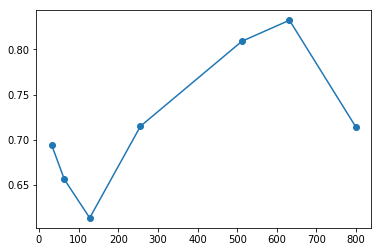

In [0]:
from matplotlib import  pyplot as plt
print(all_test)
#reset_callbacks()
values2 = [32, 64, 128, 256, 512, 632, 800]
all_test_30 = [0.6942572516498068, 0.6562450903377848, 0.6137457657336424, 0.7149497249098843, 0.8087702573879886, 0.8319882611885546, 0.7137942896456828] #30 pq es igual pero la patience del es era 30
plt.plot(values2, all_test_30, label='test', marker='o')
#pyplot.legend()
plt.show()

In [0]:
X_train2, y_train, X_test2, y_test = split_dataset(df3, 512)

In [0]:
print(X_test.shape)
print(y_test.shape)
print(X_train.shape)
print(y_train.shape)

(2907, 800, 2)
(5245, 1)
(8962, 800, 2)
(24513, 1)
